## Libraries

In [19]:
from SoundDSConv import SoundDSConv
from AutoEncoderConv import AutoEncoderConv

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
import torchaudio
from torchaudio import transforms
import os
import pandas as pd
import matplotlib.pyplot as plt

## Data Import

In [13]:
path_do_data_dir = 'DATA/'

# Get the list of files in the 'Piano Loops' directory using os.listdir()
piano_file_list = [path_do_data_dir + 'Piano Loops/' + filename for filename in os.listdir(path_do_data_dir + 'Piano Loops')]

# Create a pandas DataFrame with the "path_to_data" and "Instrument" columns for "Piano" entries
piano_df = pd.DataFrame({"path_to_data": piano_file_list, "Instrument": "Piano"})

# Get the list of files in the 'Guitar Loops' directory using os.listdir()
guitar_file_list = [path_do_data_dir + 'Guitar Loops/' + filename for filename in os.listdir(path_do_data_dir + 'Guitar Loops')]

# Create a DataFrame with the "path_to_data" and "Instrument" columns for "Guitar" entries
guitar_df = pd.DataFrame({"path_to_data": guitar_file_list, "Instrument": "Guitar"})


In [14]:
# Create Datasets
sample_rate = 5000
piano_ds = SoundDSConv(piano_df, sr = sample_rate, duration = 8)
guitar_ds = SoundDSConv(guitar_df, sr = sample_rate, duration = 8)

# Split train
piano_ds_train, piano_ds_test = random_split(piano_ds, [len(piano_ds) - 2, 2])
guitar_ds_train, guitar_ds_test = random_split(piano_ds, [len(piano_ds) - 2, 2])

1. Change the random_split before because of leake

## Check shape of dataset

In [15]:
piano_ds[0].shape

torch.Size([1, 513, 78])

## Create Model

In [16]:
encoder_layers = {'channels': [1, 5, 10],
                  'kernel_conv': [3, 3],
                  'padding': [1, 1],
                  'stride_conv': [1,1],
                  'kernel_pool': [2, 2],
                  'stride_pool': [2, 2]}

decoder_layers = {'channels': [10, 5, 1],
                  'kernel': [2,(3,4)],
                  'padding': [0, 0],
                  'stride':[2,2]}

autoencoder = AutoEncoderConv(encoder_layers, decoder_layers)

In [24]:
print(autoencoder)

AutoEncoderConv(
  (encoder): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(10, 5, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(5, 1, kernel_size=(3, 4), stride=(2, 2))
  )
)


## Train the model

In [17]:
loss = autoencoder.train(piano_ds_train, batch_size = 5, epochs = 30, lr = 0.001, optimizer = 'adam', verbose = 3)

Epoch: 1 | Batch number: 3 | Loss: 9060.2099609375 | Time: 0.45 s
Epoch: 1 | Batch number: 6 | Loss: 4974.9296875 | Time: 0.33 s
Epoch: 1 | Batch number: 9 | Loss: 22408.037109375 | Time: 0.28 s
Epoch: 1 | Batch number: 12 | Loss: 5014.21044921875 | Time: 0.29 s
Epoch: 1 | Batch number: 15 | Loss: 15103.5791015625 | Time: 0.29 s
Epoch: 1 | Batch number: 18 | Loss: 3953.247314453125 | Time: 0.31 s
Epoch: 2 | Batch number: 3 | Loss: 28262.673828125 | Time: 0.42 s
Epoch: 2 | Batch number: 6 | Loss: 5513.2587890625 | Time: 0.26 s
Epoch: 2 | Batch number: 9 | Loss: 3017.342529296875 | Time: 0.27 s
Epoch: 2 | Batch number: 12 | Loss: 1671.165283203125 | Time: 0.24 s
Epoch: 2 | Batch number: 15 | Loss: 3293.130859375 | Time: 0.27 s
Epoch: 2 | Batch number: 18 | Loss: 3518.35791015625 | Time: 0.28 s
Epoch: 3 | Batch number: 3 | Loss: 5847.16748046875 | Time: 0.43 s
Epoch: 3 | Batch number: 6 | Loss: 1615.3184814453125 | Time: 0.28 s
Epoch: 3 | Batch number: 9 | Loss: 1315.333984375 | Time: 0.2

## Plotting the error

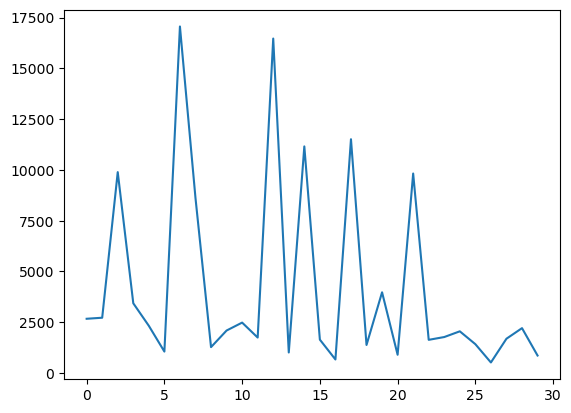

In [20]:
plt.plot(loss)
plt.show()

## Testing it

In [21]:
# From spectrogram to waveform
def recover_waveform(spec):
        griffin_lim = transforms.GriffinLim(n_fft=1024,
                                             hop_length=512)

        rec_waveform = griffin_lim(spec)

        return rec_waveform

In [23]:
# Predicting
testing = piano_ds_test[0]
testing_out = autoencoder(testing)

# Reshaping
testing_out_shaped = testing_out.reshape(1, piano_ds.spec_size[0], piano_ds.spec_size[1]).detach()
testing_shaped = testing.reshape(1, piano_ds.spec_size[0], piano_ds.spec_size[1]).detach()

# Capping minimum value
testing_out_shaped = testing_out_shaped.clamp(min = 0.0)

in_wave = recover_waveform(testing_shaped)
out_wave = recover_waveform(testing_out_shaped)

input_path = "input_audio.wav"
output_path = "output_audio.wav"
torchaudio.save(input_path, in_wave, sample_rate)
torchaudio.save(output_path, out_wave, sample_rate)